# Extraemos todas las features del paciente 5   

In [1]:
#Importación de librerías
# generales
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mne import io
# propias
from FVfunctions import getMeData, getMeFeatures
from dataset_reader import get_seizure_events, get_seizure_array
from online_test import online_test
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn import model_selection as ms

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATASET_DIR = r"../eeg_dataset/physionet.org/files/siena-scalp-eeg/1.0.0/"
edf_names = []
seizure_events = []

for directory in os.listdir(DATASET_DIR):
    print('='*50)
    print(f"{directory: ^50}")
    print('='*50)
    
    for filename in os.listdir(os.path.join(DATASET_DIR, directory)):
        if '.edf' in filename:
            edf_names.append(f"{DATASET_DIR}/{directory}/{filename}")
        elif '.txt' in filename:
            new_seizures = get_seizure_events(f"{DATASET_DIR}/{directory}/{filename}")
            seizure_events.extend(new_seizures)
            for event in new_seizures:
                print('\n'.join([f"{key}: {val}" for key, val in event.items()]))
                print()

print(edf_names)

                       PN01                       
seizure_number: 1
file_name: PN01-1.edf
registration_start_time: 19.00.44
registration_end_time: 08.29.41
seizure_start_time: 21.51.02
seizure_end_time: 21.51.56

seizure_number: 2
file_name: PN01-1.edf
registration_start_time: 19.00.44
registration_end_time: 08.29.41
seizure_start_time: 07.53.17
seizure_end_time: 07.54.31

                       PN05                       
seizure_number: 2
file_name: PN05-2.edf
registration_start_time: 06.46.02
registration_end_time: 09.19.47
seizure_start_time: 08.45.25
seizure_end_time: 08.46.00

seizure_number: 3
file_name: PN05-3.edf
registration_start_time: 06.01.23
registration_end_time: 08.06.57
seizure_start_time: 07.55.19
seizure_end_time: 07.55.49

seizure_number: 4
file_name: PN05-4.edf
registration_start_time: 06.38.35
registration_end_time: 08.00.23
seizure_start_time: 07.38.43
seizure_end_time: 07.39.22

                       PN09                       
seizure_number: 1
file_name: PN0

In [14]:
channels = ['EEG T3', 'EEG T5'] #, 'EEG F7', 'EEG F3', 'EEG C3', 'EEG P3']
feature_vectors = []
labels = []
fs = None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for edf in edf_names:
        # Paso 1: duracion de señal y seizures
        name = edf.split('/')[-1]

        print('='*50)
        print(f"{name: ^50}")
        print('='*50)

        this_seizure_events = [seiz for seiz in seizure_events if seiz["file_name"]==name]
        if len(this_seizure_events) == 0:
            print('nada en', name)
            continue
            
        ex_seiz = this_seizure_events[0]
        mtx_t_reg = np.array([ex_seiz['registration_start_time'], ex_seiz['registration_end_time']])
        arr_mtx_t_epi = get_seizure_array(this_seizure_events)
    
        # Paso 2: extraemos la señal
        raw = io.read_raw_edf(edf)
        print('\n\n')
        if fs is None:
            fs = raw.info['sfreq']
        raw_filt = raw.pick(channels)
        data_namefilt = raw_filt.get_data() * 1e6
    
        # Paso 3: sacamos segmentos y features
        new_seg_list, new_label = getMeData(data_namefilt,
                                            mtx_t_reg,
                                            arr_mtx_t_epi,
                                            winlen=2,
                                            proportion=0.5)
        new_features = getMeFeatures(new_seg_list, channels, fs)
        feature_vectors.append(new_features)
        labels.append(new_label)

labels_arr = np.concatenate(labels)
df_fv = pd.concat(feature_vectors)
df_fv

                    PN01-1.edf                    
Extracting EDF parameters from C:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN01\PN01-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



                    PN05-2.edf                    
Extracting EDF parameters from C:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



                    PN05-3.edf                    
Extracting EDF parameters from C:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



                    PN05-4.edf                    
Extracting EDF parameters from C:\Users\gonza\Documents

,EEG T3_potRelDelta,EEG T3_potRelTheta,EEG T3_potRelAlpha,EEG T3_potRelBeta,EEG T3_potRelGamma,EEG T5_potRelDelta,EEG T5_potRelTheta,EEG T5_potRelAlpha,EEG T5_potRelBeta,EEG T5_potRelGamma,...,EEG T3_RMS,EEG T3_skewness,EEG T3_media,EEG T3_devest,EEG T5_kurtosis,EEG T5_RMS,EEG T5_skewness,EEG T5_media,EEG T5_devest,coordination
0,23.276616,6.210865,2.932189,4.657379,3.814780,14.690092,8.835453,4.791117,3.270784,3.155852,...,13.951921,-1.471574,-7.274275,11.905504,2.419868,10.206497,-1.032251,-4.405921,9.206543,0.972647
1,96.276003,53.237399,26.920170,67.273853,56.390318,59.332436,46.356260,10.306406,15.775658,20.837558,...,20.263972,-0.341136,-4.721904,19.706146,-0.140808,14.895647,-0.425440,-2.999120,14.590599,0.941827
2,5.738934,1075.093137,35.279142,6.684161,2.121499,18.025648,671.347737,28.813754,5.698928,1.130382,...,33.084309,-0.234021,-2.184331,33.012122,-0.483897,25.834867,-0.218838,-1.712191,25.778067,0.985169
3,16.459254,1850.442438,61.053070,63.599086,23.720996,15.575237,866.139183,24.611739,23.624517,11.553897,...,46.699844,-0.317577,-2.866577,46.611781,-1.015436,31.805673,-0.275012,0.833132,31.794759,0.980684
4,116.701742,3604.659597,216.126979,14.708899,14.168162,57.806747,1645.884688,80.978006,10.162567,6.078664,...,63.985770,-0.323435,-1.132473,63.975747,-1.149240,42.760578,-0.324450,-1.490291,42.734601,0.989380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,69.477103,38.260909,18.799820,16.646370,22.536339,348.234555,199.748971,52.633355,13.371329,8.718405,...,15.485352,-0.416753,-4.453411,14.831158,1.013275,28.143872,-0.227676,-2.061007,28.068305,0.818944
103,176.174189,25.865657,6.060649,12.464937,15.037122,3532.889518,57.685917,13.198881,34.710700,36.825465,...,32.252635,-0.862233,1.527369,32.216449,-0.864146,172.160583,-0.317928,143.308028,95.404798,0.960624
104,7.755669,2.698358,4.125550,11.602707,8.415538,3.408923,5.290297,13.654404,16.485641,3.727797,...,9.101002,-0.012617,-4.620394,7.840931,-0.183228,36.276663,-0.016673,-35.564945,7.150592,0.705124
105,36.709950,21.196678,10.897680,7.483317,3.027896,69.343601,36.616125,14.277972,7.320707,7.680389,...,9.917824,-1.186385,-2.289762,9.649882,4.588312,12.358900,-1.821349,-0.574690,12.345532,0.935733


# MACHINE LEARNING

In [15]:
train_x, test_x, train_y, test_y = train_test_split(df_fv, labels_arr, test_size=0.2, random_state=0)

alpha_star = 0.015000000000000999


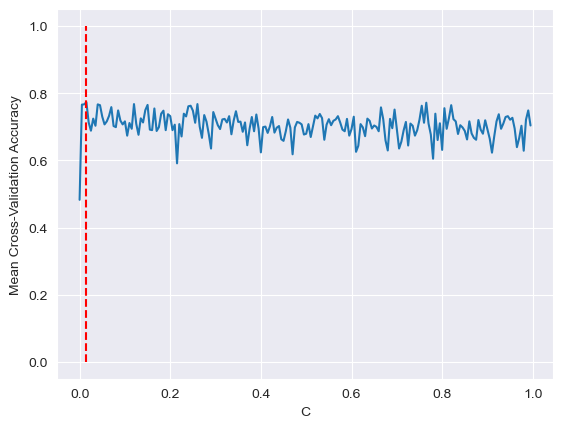

In [10]:
C = np.arange(1e-15,1,0.005) # Range of hyperparameter values 1E-15 to 1 by 0.005
val_scores = np.zeros((len(C),1)) # Initialize validation score for each alpha value


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(len(C)): # for each C value
        # Set up SVM with hinge loss and l2 norm regularization
        model = LinearSVC(dual=True,C=C[i])
        # Calculate cross validation scores for 5-fold cross-validation
        score = ms.cross_val_score(model, df_fv, labels_arr, cv=5)
        val_scores[i] = score.mean() # Calculate mean of the 5 scores

# Determine the alpha that maximizes the cross-validation score
ind = np.argmax(val_scores)
C_star = C[ind]
print('alpha_star =', C_star)

# Plot accuracy
plt.plot(C,val_scores)
plt.plot(np.ones(11)*C_star,np.arange(0,1.1,0.1),'--r')
plt.xlabel('C')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.grid(True)
plt.show()

0.8326530612244898


C:\Users\gonza\miniconda3\envs\psivenv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<Axes: >

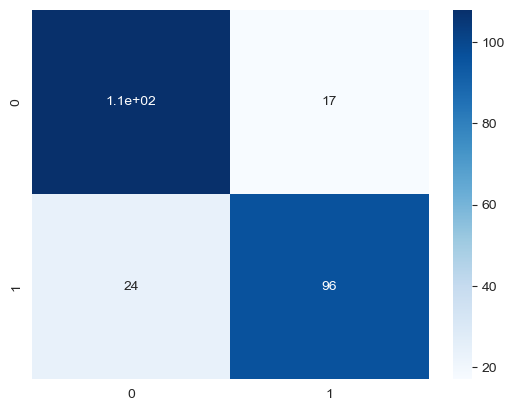

In [16]:
# testeamos en un modelo lineal
linear_model = LinearSVC(dual=True,max_iter=2000,C=C_star)
linear_model.fit(train_x, train_y)
predictions = linear_model.predict(test_x)
print(accuracy_score(test_y, predictions))
cm = confusion_matrix(test_y, predictions)
sns.heatmap(cm, cmap='Blues', annot=True)

0.5183673469387755


<Axes: >

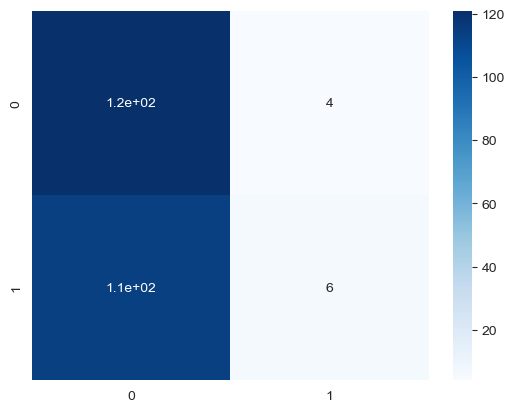

In [18]:
# kernel
rbf_model = SVC(kernel='rbf')
rbf_model.fit(train_x, train_y)
rbf_pred = rbf_model.predict(test_x)
print(accuracy_score(test_y, rbf_pred))
cm_rbf = confusion_matrix(test_y, rbf_pred)
sns.heatmap(cm_rbf, annot=True, cmap='Blues')

In [22]:
# with open('pretrained_models/2-ch-gonza.pkl', 'wb') as file:
#     pickle.dump(linear_model, file)

0.8326530612244898


Text(52.72222222222221, 0.5, 'True label')

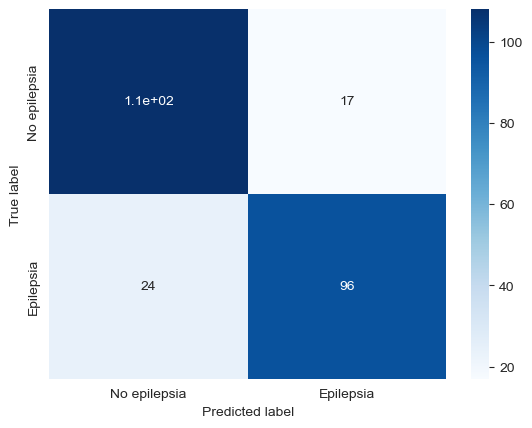

In [23]:
with open(r'pretrained_models/2-ch-gonza.pkl', 'rb') as file:
    modelo_leido = pickle.load(file)

clasificaciones = ["No epilepsia","Epilepsia"]


predictions = modelo_leido.predict(test_x)
print(accuracy_score(test_y, predictions))
cm = confusion_matrix(test_y, predictions)

cm_df = pd.DataFrame(data=cm,index=clasificaciones,columns=clasificaciones)

ax = sns.heatmap(cm_df, cmap='Blues', annot=True)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# LUKITESTING

In [8]:
modelos = []
scores = []

iteraciones = 100

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(iteraciones):
        linear_model = LinearSVC(dual=True,max_iter=2000)
        linear_model.fit(train_x, train_y)
        predictions = linear_model.predict(test_x)
        score = accuracy_score(test_y, predictions)
        
        modelos.append(linear_model)
        scores.append(score)
        
arr_n = np.arange(len(scores))

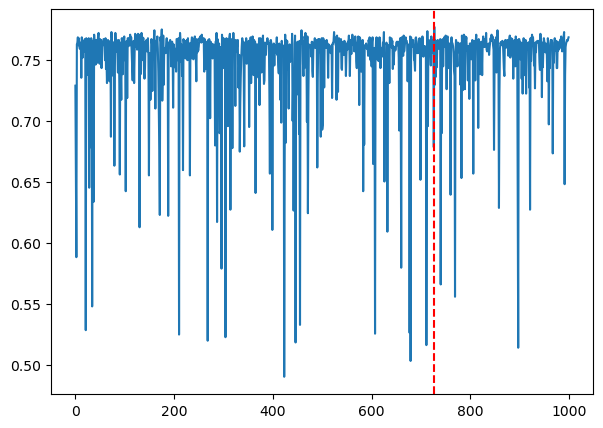

In [9]:
ind = np.argmax(scores)
n = arr_n[ind]

plt.figure(figsize=(7,5))
plt.plot(arr_n,scores)
plt.axvline(x=n,linestyle="--",color="red")
plt.show()



0.7768178545716342


Text(50.72222222222221, 0.5, 'True label')

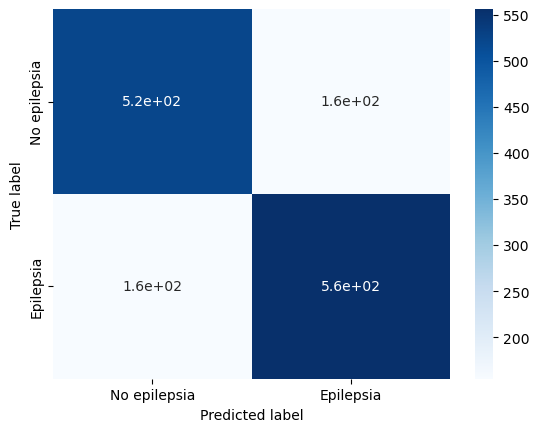

In [10]:
ind = np.argmax(scores)
modelo_star = modelos[ind]

predictions = modelo_star.predict(test_x)
print(accuracy_score(test_y, predictions))
cm = confusion_matrix(test_y, predictions)

clasificaciones = ["No epilepsia","Epilepsia"]
cm_df = pd.DataFrame(data=cm,index=clasificaciones,columns=clasificaciones)

ax = sns.heatmap(cm_df, cmap='Blues', annot=True)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# LUKITESTING - PT.2 - ML para segmentar EEGs

In [4]:
with open(r'pretrained_models/2-ch-gonza.pkl', 'rb') as file:
    modelo_leido = pickle.load(file)

In [ ]:
channels = ['EEG T3', 'EEG T5'] #, 'EEG F7', 'EEG F3', 'EEG C3', 'EEG P3']
indexes = []
labels = []
fs = None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for edf in edf_names:
        # Paso 1: duracion de señal y seizures
        name = edf.split('/')[-1]
        this_seizure_events = [seiz for seiz in seizure_events if seiz["file_name"]==name]
        
        if len(this_seizure_events) == 0:
            print('nada en', name)
            continue
            
        ex_seiz = this_seizure_events[0]
        mtx_t_reg = np.array([ex_seiz['registration_start_time'], ex_seiz['registration_end_time']])
        arr_mtx_t_epi = get_seizure_array(this_seizure_events)
    
        # Paso 2: extraemos la señal
        raw = io.read_raw_edf(edf)
        print('\n\n')
        if fs is None:
            fs = raw.info['sfreq']
        raw_filt = raw.pick(channels)
        data_namefilt = raw_filt.get_data() * 1e6

        # Ploteamos la clasificación aplicada "en tiempo real"
        online_test(modelo_leido, data_namefilt, channels, this_seizure_events, name, fs)


Extracting EDF parameters from C:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN01\PN01-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



segmentando las señales de PN01-1.edf...
(24268, 1024)
extrayendo las features de PN01-1.edf...
